### Configure the model

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(model='gemini-1.5-flash')
output = model.invoke("hi")
print(output.content)

### Configure the embedding model

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
len(embeddings.embed_query("hi"))

### Let's take data, embed and store in Vector Database

In [ ]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [ ]:
loader=DirectoryLoader("../data",glob="./*.txt",loader_cls=TextLoader)

In [ ]:
docs=loader.load()

In [ ]:
docs

In [ ]:
docs[0].page_content

In [ ]:
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)

In [ ]:
new_docs=text_splitter.split_documents(documents=docs)

In [ ]:
new_docs


In [ ]:
doc_string=[doc.page_content for doc in new_docs]


In [ ]:
doc_string

In [ ]:
len(doc_string)

In [ ]:
import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore

index=faiss.IndexFlatL2(384)

db=FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

In [ ]:
db.add_texts(doc_string)

In [ ]:
retriever=db.as_retriever(search_kwargs={"k": 3})


In [ ]:
retriever.invoke("industrial growth of usa?")


### creating pydantic class

In [ ]:
import operator
from typing import List
from pydantic import BaseModel , Field
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END

In [ ]:
class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description='Reasoning behind topic selection')

In [ ]:
from langchain.output_parsers import PydanticOutputParser
parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [ ]:
parser.get_format_instructions()

### How State Graph work?

#### Normal AgenState Dictionary

In [ ]:
Agentstate={}


In [ ]:
Agentstate["messages"]=[]


In [ ]:
Agentstate

In [ ]:
Agentstate["messages"].append("hi how are you?")


In [ ]:
Agentstate

In [ ]:
Agentstate["messages"].append("what are you doing?")


In [ ]:
Agentstate

In [ ]:
Agentstate["messages"].append("i hope everything fine")


In [ ]:
Agentstate

In [ ]:
Agentstate["messages"][-1]


In [ ]:
Agentstate["messages"][0]


#### Using AgentState inside StateGraph

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [ ]:
def function1(state: AgentState):
    question = state["messages"][-1]

    print("Question", question)

    template="""
    Your task is to classify the given user query into one of the following categories: [USA,Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions}
    )

    chain = prompt | model | parser

    response = chain.invoke({"question": question})

    print("Parsed response", response)

    return {"messages": [response.Topic]}

In [ ]:
state={"messages":["what is a today weather?"]}

In [ ]:
function1(state)

In [ ]:
state={"messages":["what is a GDP of usa??"]}
function1(state)

In [ ]:
def router(state: AgentState):
    print("-> Router ->")

    last_message = state["messages"][-1]
    print("last_message: ", last_message)

    if "usa" in last_message.lower():
        return "RAG Call"
    else:
        return "LLM Call"

In [ ]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [ ]:
# RAG Function
def function2(state: AgentState):
    print("-> RAG Call ->")
    question = state["messages"][0]
    
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [result]}

In [ ]:
# LLM Function
def function3(state: AgentState):
    print("-> LLM Call ->")
    question = state["messages"][0]
    
    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = model.invoke(complete_query)
    return {"messages": [response.content]}

In [ ]:
from langgraph.graph import StateGraph, END

In [ ]:
workflow = StateGraph(AgentState)

In [ ]:
workflow.add_node("Supervisor", function1)

In [ ]:
workflow.add_node("RAG", function2)

In [ ]:
workflow.add_node("LLM", function3)

In [ ]:
workflow.set_entry_point("Supervisor")

In [ ]:
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG Call" : "RAG",
        "LLM Call" : "LLM"
    }
)

In [ ]:
workflow.add_edge("RAG", END)
workflow.add_edge("LLM", END)

In [ ]:
app = workflow.compile()

In [ ]:
app

In [ ]:
state = {"messages": ["Hi"]}

In [ ]:
app.invoke(state)

In [ ]:
state={"messages":["what is a gdp of usa?"]}


In [ ]:
app.invoke(state)

In [ ]:
state={"messages":["can you tell me the industrial growth of world's most powerful economy?"]}

app.invoke(state)

In [ ]:
state={"messages":["can you tell me the industrial growth of world's poor economy?"]}

app.invoke(state)

# Assignment

1. you have to create one supervisor node.
2. create one router function
3. create three more node
3.1 llm call (llm node)
3.2 RAG (rag node)
3.3 web crawler(fetch the info in realtime from internet)
4. created one more node after this for validation for generated output --> explore the validation part how to do that
5. if validation going to be failed in that case again go to supervioser node and then supervisor node will again decide what needs to be call next
6. once the validation will pass then only generate the final output

In [1]:
import operator
from typing import List
from pydantic import BaseModel , Field
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END

### Getting LLM Model

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
model=ChatGoogleGenerativeAI(model='gemini-1.5-flash')
output=model.invoke("hi")
print(output.content)

Hi there! How can I help you today?


In [3]:
import os
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

from langchain_groq import ChatGroq

model = ChatGroq(model = "qwen-qwq-32b")
model.invoke("Hi, my name is Kingpin")

AIMessage(content='\n<think>\nOkay, the user just introduced themselves as "Kingpin." I should respond politely, maybe acknowledge their name, and offer help. Let me keep it friendly and open-ended so they feel comfortable to ask anything. I\'ll make sure to follow the guidelines: be helpful, conversational, and not assume too much. Let\'s see... "Hi Kingpin! How can I assist you today?" That sounds good. It\'s simple, acknowledges their name, and invites them to state their needs. I\'ll send that.\n\n</think>\n\nHi Kingpin! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 120, 'prompt_tokens': 17, 'total_tokens': 137, 'completion_time': 0.275967769, 'prompt_time': 0.002930897, 'queue_time': 0.217929863, 'total_time': 0.278898666}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_ea798e78f0', 'finish_reason': 'stop', 'logprobs': None}, id='run--ec972ec0-f263-4eae-8dc9-b670c50f0707-0', usage_metadata={'input_tokens': 17

### Getting Embedding Model

In [4]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
len(embeddings.embed_query("hi"))

g:\AgenticAI\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


384

### Creating Vector Store

In [5]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore

loader=DirectoryLoader("../data",glob="./*.txt",loader_cls=TextLoader)

text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)

docs=loader.load()

new_docs=text_splitter.split_documents(documents=docs)

doc_string=[doc.page_content for doc in new_docs]

index=faiss.IndexFlatL2(384)

db=FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

db.add_texts(doc_string)

['ba48d578-19ef-43da-a669-3552bc5e968c',
 '705d6a6c-31bf-4db2-9e72-52dac0c48aa4',
 'c5744878-a656-4472-bf04-13bbba2b2419',
 'a7f2fc05-cc97-415d-abb4-a87387c45e58',
 'f9fac6c0-2294-413f-86c0-e473cf7dac04',
 '20f008b5-06c5-4642-81d4-f94d5eb3c5ac',
 '681ae58d-f246-4957-93f6-e2cabe846a5e',
 '6dd0c4d3-0f81-4f0a-af22-52b12ff4c553',
 '29bde614-c781-4718-ba94-42623897cc34',
 '0d757ce3-6947-45c3-b82d-b19fa1de6ae2',
 '4f972cc0-6279-43a6-9a81-505e4d712b18',
 '59c3ee35-5ca0-4923-95f0-23f7e56ef493',
 '5986bda6-6abf-437b-bfc5-171a40ec8e3b',
 'ba0317b8-fcc9-4f48-af9f-2177682e17fb',
 'a1c5454a-105e-4a29-84fe-11643c355e7a',
 '0238fec5-89f8-4a70-8ed7-0fbb5c50d7f7',
 'dca4025a-7497-4da0-9d5f-635152defeed',
 '6b7a4ceb-ecb3-4008-b1d9-6cd18af9a9f4',
 '2bb52f89-c7cc-4760-9fc4-78b1dfbe7899',
 '662a81cf-08ec-40e9-a83c-823f4cb4b8f4',
 '1d524514-65a1-40f7-b39c-694c3c9d164a',
 '796eb286-fdd3-4d0b-8dde-a9abda99b32f',
 '30e47a11-2797-4491-a9e6-566c7d897abb',
 '06a90d34-414e-4ce7-9f1e-f125eedfb20c',
 'ea4be1ed-732f-

In [6]:
# Initializing retriever

retriever=db.as_retriever(search_kwargs={"k": 3})

In [7]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

### Using Pydantic

In [8]:
from pydantic import BaseModel , Field
from langchain.output_parsers import PydanticOutputParser

class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description='Reasoning behind topic selection')


parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [9]:
class ValidationParser(BaseModel):
    Topic:str=Field(description="selected topic")

val_parser=PydanticOutputParser(pydantic_object=ValidationParser)

In [10]:
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "selected topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

### Writing Agent State

In [11]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [12]:
workflow = StateGraph(AgentState)

In [13]:
def function1(state: AgentState):
    question=state["messages"][-1]
    
    print("Question",question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [USA, LLM, Internet].
    'LLM': If it is general query on something in the LLMs scope; 'Internet': If the knowledge is very current and can only be determined via Internet Search. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    
    prompt= PromptTemplate(
        template=template,
        input_variable=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    
    
    chain= prompt | model | parser
    
    response = chain.invoke({"question":question})
    
    print("Parsed response:", response)
    
    return {"messages": [response.Topic]}

In [14]:
def router(state: AgentState):
    print("-> ROUTER ->")

    last_message = state["messages"][-1]

    print("Last Message - ", last_message)

    if "usa" in last_message.lower():
        return "RAG Call"
    elif "llm" in last_message.lower():
        return "LLM Call"
    else:
        return "Internet Call"

In [15]:
def function2(state: AgentState):
    print("-> LLM Call ->")
    question = state["messages"][0]
    
    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = model.invoke(complete_query)
    return {"messages": [response.content]}

In [16]:
def function3(state: AgentState):
    print("-> RAG Call ->")
    
    question = state["messages"][0]
    
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [result]}

In [17]:
from langchain_tavily import TavilySearch
import os
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")

In [18]:
def function4(state: AgentState):
    print("Internet Call")
    tavily_tool=TavilySearch(tavily_api_key=TAVILY_API_KEY)
    question = state["messages"][0]

    complete_query = "Anwer the follow question by searching the internet and getting best response. Following is the user question: " + question
    response = tavily_tool.invoke(complete_query)

    results = response.get("results", [])

    if isinstance(results, list) and len(results) > 0:
        top_result = results[0]
        title = top_result.get("title", "Source")
        content = top_result.get("content", "No summary available.")
        url = top_result.get("url", "")

        # Nicely formatted Markdown message
        top_answer = f"{content}"
    else:
        top_answer = "Sorry, I couldn't find any relevant results."

    return {"messages": [top_answer]}
    

In [19]:


# def function5(state: AgentState):
#     print("-> Validation Call ->")
#     question = state["messages"][0]
#     result = state["messages"][-1]
    
#     template="""
#     Your task is to classify the result for the user query into one of the following categories: [Relevant, Irrelevant]. 
#     Only respond with the category name and nothing else.

#     User query: {question}
#     Result: {result}
#     {format_instructions}
#     """
    
#     prompt= PromptTemplate(
#         template=template,
#         input_variables=["question", "result"],
#         partial_variables={"format_instructions": val_parser.get_format_instructions()}
#     )
    
    
#     chain= prompt | model | val_parser
    
#     response = chain.invoke({"question":question, "result": result})
    
#     print("Parsed response:", response)
    
#     return {"messages": [response.Topic]}

In [20]:
from langchain_core.output_parsers.string import StrOutputParser

def function5(state: AgentState):
    print("-> Validation Call ->")
    question = state["messages"][0]
    result = state["messages"][-1]

    template = """
    Your task is to classify the result for the user query into one of the following categories: [Relevant, Irrelevant].

    Only respond with one word: "Relevant" or "Irrelevant".
    Do not include any other text, explanation, or formatting.

    User query: {question}
    Result: {result}
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=["question", "result"]
    )

    chain = prompt | model | StrOutputParser()

    raw_response = chain.invoke({"question": question, "result": result})

    # Normalize the output to ensure safety
    label = raw_response.strip().lower()
    if "relevant" in label:
        label = "Relevant"
    elif "irrelevant" in label:
        label = "Irrelevant"
    else:
        label = "Irrelevant"  # fallback

    return {"messages": [label]}

In [21]:
def router2(state: AgentState):
    print("-> ROUTER2 ->")

    last_message = state["messages"][-1]

    print("Last Message - ", last_message)

    if "relevant" in last_message.lower():
        return "Satisfied"
    else:
        return "Not Satisfied"

In [22]:
workflow.add_node("Supervisor", function1)

In [23]:
workflow.add_node("LLM", function2)

In [24]:
workflow.add_node("RAG", function3)

In [25]:
workflow.add_node("Internet", function4)

In [26]:
workflow.add_node("Validation", function5)

In [27]:
workflow.set_entry_point("Supervisor")

In [28]:
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "LLM Call": "LLM",
        "RAG Call": "RAG",
        "Internet Call": "Internet"
    }
)

In [29]:
workflow.add_edge("LLM", "Validation")

In [30]:
workflow.add_edge("RAG", "Validation")

In [31]:
workflow.add_edge("Internet", "Validation")

In [32]:
workflow.add_conditional_edges(
    "Validation",
    router2,
    {
        "Satisfied": END,
        "Not Satisfied": "Supervisor"
    }
)

In [33]:
app = workflow.compile()

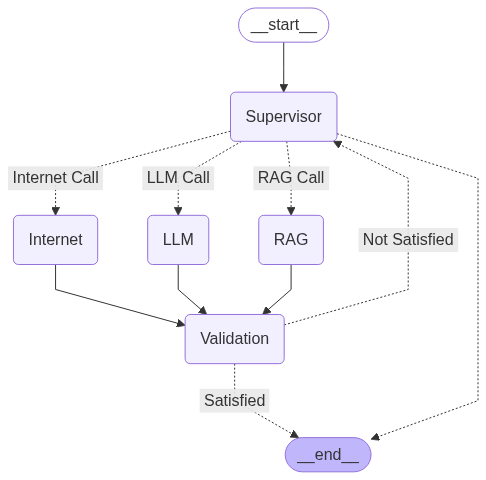

In [34]:
app

In [35]:
state={"messages":["what is a gdp of usa?"]}
app.invoke(state)

Question what is a gdp of usa?
Parsed response: Topic='Internet' Reasoning="The GDP of the USA is a current economic figure that requires the latest data, which may not be in the LLM's training data and necessitates an internet search for up-to-date information."
-> ROUTER ->
Last Message -  Internet
Internet Call
-> Validation Call ->
-> ROUTER2 ->
Last Message -  Relevant


{'messages': ['what is a gdp of usa?',
  'Internet',
  'Gross Domestic Product, 1st Quarter 2025 (Advance Estimate) | U.S. Bureau of Economic Analysis (BEA) **Real gross domestic product (GDP)** decreased at an annual rate of 0.3 percent in the first quarter of 2025 (January, February, and March), according to the advance estimate released by the U.S. Bureau of Economic Analysis. Real GDP decreased at an annual rate of 0.3 percent (less than 0.1 percent at a quarterly rate 1) in the first quarter, primarily reflecting an increase in imports and a decrease in government spending that were partly offset by increases in investment, consumer spending, and exports. More information on the source data and BEA assumptions that underlie the first-quarter estimate is shown in the key source data and assumptions table (available at 10 a.m.).',
  'Relevant']}

In [36]:
state={"messages":["What is LLM?"]}
app.invoke(state)



Question What is LLM?
Parsed response: Topic='LLM' Reasoning="The query asks for the definition/explanation of 'LLM' (Large Language Model), which is a core concept within the scope of LLMs themselves. This doesn't require current/event-specific internet knowledge and is general technical knowledge."
-> ROUTER ->
Last Message -  LLM
-> LLM Call ->
-> Validation Call ->
-> ROUTER2 ->
Last Message -  Relevant


{'messages': ['What is LLM?',
  'LLM',
  '\n<think>\nOkay, the user is asking, "What is LLM?" I need to explain what an LLM is. Let me start by recalling that LLM stands for Large Language Model. I should define it in simple terms first.\n\nAn LLM is a type of artificial intelligence designed to process and generate human-like text. These models are trained on vast amounts of internet text data. I should mention some key characteristics, like their size in terms of parameters. I remember that LLMs have billions of parameters, which makes them more powerful than smaller models.\n\nI should also explain how they\'re trained. They\'re trained using machine learning techniques, often with unsupervised or semi-supervised learning, to predict the next word in a sequence. This helps them understand context and generate coherent responses. Maybe I should give examples of popular LLMs, like GPT, BERT, or the ones from OpenAI or Google\'s models like LaMDA or PaLM.\n\nIt\'s important to note the

In [39]:
state={"messages":["From the data, tell me how do we get the GDP of USA?"]}
app.invoke(state)


Question From the data, tell me how do we get the GDP of USA?
Parsed response: Topic='USA' Reasoning='The query asks about obtaining the GDP of the USA, which relates to economic data specific to the United States. The methodology for calculating GDP (e.g., through government sources like the Bureau of Economic Analysis) is established knowledge within the scope of LLMs, not requiring real-time internet search.'
-> ROUTER ->
Last Message -  USA
-> RAG Call ->
-> Validation Call ->
-> ROUTER2 ->
Last Message -  Relevant


{'messages': ['From the data, tell me how do we get the GDP of USA?',
  'USA',
  '\n<think>\nOkay, the user is asking how we get the GDP of the USA. Let me check the provided context. The context mentions "U.S. GDP – Size, Composition, and Global Share" and "GDP Growth Trends and Dynamics". But wait, those titles don\'t actually explain the calculation method. The user wants to know the method of calculating GDP. The context here doesn\'t go into the details like expenditure approach (C+I+G+NX) or income approach. Since the given context doesn\'t provide the method, I should state that I don\'t know based on the provided information. I need to make sure not to use external knowledge here. The answer should be that the provided contexts don\'t explain the calculation method, so I can\'t answer with the given data.\n</think>\n\nThe provided contexts mention U.S. GDP\'s size, composition, global share, and growth trends but do not explain the methodology for calculating GDP. Without speci